### 1. Install Required Dependencies

In [ ]:
!pip install sentence-transformers

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

### 2. Mount drive & Load data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_json('/content/drive/MyDrive/Colab Notebooks/Intro_to_Machine_Learning/politifact_factcheck_data.json', lines=True)
df['verdict'].value_counts()

,count
verdict,
false,5625
half-true,3597
mostly-false,3432
mostly-true,3332
pants-fire,2703
true,2463


### 3. Preprocess

#### 3-1. Filter ambiguos statements & binarize labels

In [5]:
print(len(df))
df = df[df['verdict'] != 'half-true'].reset_index(drop=True)
df = df[df['verdict'] != 'mostly-false'].reset_index(drop=True)
print(len(df))

21152
14123


In [6]:
# Binarize the labels
binary_map = {
    'true': 0,
    'mostly-true': 0,
    'false': 1,
    'pants-fire': 1
}
df['binary_verdict'] = df['verdict'].map(binary_map)
df['binary_verdict'].value_counts()

,count
binary_verdict,
1,8328
0,5795


#### 3-2. Discard unused metadata (e.g., `factcheck_date`, `factcheck_analysis_link`, etc.)

In [8]:
df = df.drop(['factchecker', 'factcheck_date', 'factcheck_analysis_link'], axis=1)
df.head(3)

,verdict,statement_originator,statement,statement_date,statement_source,binary_verdict
0,true,Barack Obama,John McCain opposed bankruptcy protections for...,6/11/2008,speech,0
1,false,Matt Gaetz,"""Bennie Thompson actively cheer-led riots in t...",6/7/2022,television,1
2,mostly-true,Kelly Ayotte,"Says Maggie Hassan was ""out of state on 30 day...",5/18/2016,news,0


#### 3-3. Split entire dataset by `train` : `valid` : `test` = 8 : 1 : 1 (fixed seed)

In [9]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['binary_verdict'])
valid_df, test_df = train_test_split(valid_df, test_size=0.5, random_state=42, stratify=valid_df['binary_verdict'])
print(len(train_df), len(valid_df), len(test_df))

11298 1412 1413


## 4. Method III : Originator Reliability (Avg. truthness + originator embedding)


#### 4-1. Find out the coverage of Top-$K$ `statement_originator`s
Empirically, we choose $K$=300 originators that appear at least  $N$=5 times in the train dataset

In [27]:
N = 5
frequent_originators = train_df["statement_originator"].value_counts() >= N
frequent_originators.sum().item()

292

Given $K$=300, **53% of statements** are covered from top 300 originators in train dataset

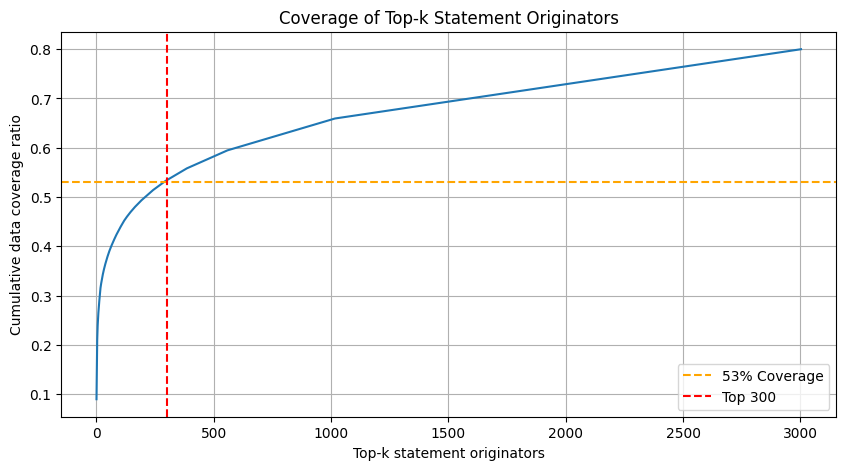

In [ ]:
# Cumulative coverage ratio
cumulative_counts = train_df["statement_originator"].value_counts().cumsum()
coverage_ratio = cumulative_counts / len(df)

# Plot coverage w.r.t to top-k originators
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(coverage_ratio)+1), coverage_ratio.values)
plt.xlabel("Top-k statement originators")
plt.ylabel("Cumulative data coverage ratio")
plt.title("Coverage of Top-k Statement Originators")
plt.grid(True)
plt.axhline(y=0.53, color='orange', linestyle='--', label='53% Coverage')
plt.axvline(x=300, color='red', linestyle='--', label="Top 300")
plt.legend()

####4-2. Retrieve top-$K$ `statement_originator`s and calculate `originator_avg_truth` per group

In [30]:
top_k = 300

top_k_train_originators = (
    train_df['statement_originator']
    .value_counts()
    .nlargest(top_k)
    .index
    .tolist()
)

# Compare with top-k originators and group rest as 'other'
def group_originators(originator):
    return originator if originator in top_k_train_originators else "other"

train_df['originator_grouped'] = train_df['statement_originator'].apply(group_originators)
valid_df['originator_grouped'] = valid_df['statement_originator'].apply(group_originators)
test_df['originator_grouped'] = test_df['statement_originator'].apply(group_originators)


# Compute average truthfulness of the statement originator (from train dataset only)
truth_map = train_df.groupby('statement_originator')['binary_verdict'].mean()
global_mean = train_df['binary_verdict'].mean()

train_df['originator_avg_truth'] = train_df['statement_originator'].map(truth_map).fillna(global_mean)
valid_df['originator_avg_truth'] = valid_df['statement_originator'].map(truth_map).fillna(global_mean)
test_df['originator_avg_truth'] = test_df['statement_originator'].map(truth_map).fillna(global_mean)
train_df.head(3)

,verdict,statement_originator,statement,statement_date,statement_source,binary_verdict,originator_grouped,originator_avg_truth
5161,false,Scott Walker,"""We’re broke. We don’t have any more money.""",2/21/2011,news,1,Scott Walker,0.404255
10333,false,Facebook posts,"""Doctor proves masks don’t work"" by vaping thr...",12/31/2020,social_media,1,Facebook posts,0.958893
12896,mostly-true,Donald Trump,Says Nancy Pelosi’s coronavirus bill includes ...,3/24/2020,campaign,0,Donald Trump,0.821497


#### 4-3. Prepare Originator Embeddings

Encode each originator name to IDs in range $[0, K]$

In [33]:
le = LabelEncoder()

originator_ids_train = le.fit_transform(train_df['originator_grouped'])
originator_ids_valid = le.transform(valid_df['originator_grouped'])
originator_ids_test = le.transform(test_df['originator_grouped'])
print(originator_ids_train[:5])
print(np.min(originator_ids_train), np.max(originator_ids_train))

[259  93  84  84 279]
0 300


In [34]:
import torch
import torch.nn as nn
import torch.nn.init as init

# np.ndarray to torch.tensor
X_train_originator_ids = torch.tensor(originator_ids_train, dtype=torch.long)
X_valid_originator_ids = torch.tensor(originator_ids_valid, dtype=torch.long)
X_test_originator_ids = torch.tensor(originator_ids_test, dtype=torch.long)

#### 4-4. Follow baseline (Get `statement_year` from `statement_date`)

In [35]:
train_df['statement_year'] = train_df['statement_date'].str.split('/').str[-1]
valid_df['statement_year'] = valid_df['statement_date'].str.split('/').str[-1]
test_df['statement_year'] = test_df['statement_date'].str.split('/').str[-1]
train_df.drop('statement_date', axis=1, inplace=True)
valid_df.drop('statement_date', axis=1, inplace=True)
test_df.drop('statement_date', axis=1, inplace=True)

#### 4-4. Follow baseline (Extract Sentence BERT embedding from each statement)

In [ ]:
from sentence_transformers import SentenceTransformer
sbert_model_name = 'all-MiniLM-L6-v2'
sbert_model = SentenceTransformer(sbert_model_name)

In [ ]:
train_statement_embeddings = sbert_model.encode(train_df['statement'].tolist(), show_progress_bar=True)
valid_statement_embeddings = sbert_model.encode(valid_df['statement'].tolist(), show_progress_bar=True)
test_statement_embeddings = sbert_model.encode(test_df['statement'].tolist(), show_progress_bar=True)

In [38]:
# np.ndarray to dataframe
embedding_dim = train_statement_embeddings.shape[1]
embedding_feature_names = [f'embed_{i}' for i in range(embedding_dim)]
train_embeddings_df = pd.DataFrame(train_statement_embeddings, columns=embedding_feature_names, index=train_df.index)
valid_embeddings_df = pd.DataFrame(valid_statement_embeddings, columns=embedding_feature_names, index=valid_df.index)
test_embeddings_df = pd.DataFrame(test_statement_embeddings, columns=embedding_feature_names, index=test_df.index)

# Combine embeddings with the original DataFrame
train_df = pd.concat([train_df.drop(['statement'], axis=1), train_embeddings_df], axis=1)
valid_df = pd.concat([valid_df.drop(['statement'], axis=1), valid_embeddings_df], axis=1)
test_df = pd.concat([test_df.drop(['statement'], axis=1), test_embeddings_df], axis=1)
train_df.head()

,verdict,statement_originator,statement_source,binary_verdict,originator_grouped,originator_avg_truth,statement_year,embed_0,embed_1,embed_2,...,embed_374,embed_375,embed_376,embed_377,embed_378,embed_379,embed_380,embed_381,embed_382,embed_383
5161,false,Scott Walker,news,1,Scott Walker,0.404255,2011,-0.055342,0.029324,0.016157,...,-0.049894,-0.040692,-0.023578,0.070436,-0.057112,-0.054528,0.056940,-0.039115,0.010386,-0.034721
10333,false,Facebook posts,social_media,1,Facebook posts,0.958893,2020,0.008371,0.070577,0.059364,...,-0.027812,-0.004499,0.046334,-0.033792,-0.057582,-0.039001,0.059064,0.010713,0.069696,0.026547
12896,mostly-true,Donald Trump,campaign,0,Donald Trump,0.821497,2020,-0.005775,0.081369,0.091523,...,-0.088440,0.016320,-0.051128,-0.078806,-0.012644,-0.042643,0.034212,-0.078945,-0.025310,-0.005026
409,pants-fire,Donald Trump,speech,1,Donald Trump,0.821497,2020,-0.084947,0.077394,0.080611,...,0.116466,0.108275,0.043569,0.019466,0.020980,0.043026,-0.022040,-0.025539,0.006419,-0.010950
12078,true,Tim Kaine,news,0,Tim Kaine,0.080000,2021,-0.063232,0.078880,0.012146,...,0.002505,-0.029684,0.064795,0.037255,-0.088508,-0.100266,-0.015884,0.021775,0.079951,0.031500


Now, `statement_originator` and `originator_grouped` is no longer used -> `originator_ids`

In [39]:
y_train = train_df.binary_verdict
y_valid = valid_df.binary_verdict
y_test = test_df.binary_verdict
X_train = train_df.drop(['verdict', 'statement_originator', 'originator_grouped', 'binary_verdict'], axis=1)
X_valid = valid_df.drop(['verdict', 'statement_originator', 'originator_grouped', 'binary_verdict'], axis=1)
X_test = test_df.drop(['verdict', 'statement_originator', 'originator_grouped', 'binary_verdict'], axis=1)
X_train.head()

,statement_source,originator_avg_truth,statement_year,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,...,embed_374,embed_375,embed_376,embed_377,embed_378,embed_379,embed_380,embed_381,embed_382,embed_383
5161,news,0.404255,2011,-0.055342,0.029324,0.016157,0.037620,0.004032,0.024392,0.087365,...,-0.049894,-0.040692,-0.023578,0.070436,-0.057112,-0.054528,0.056940,-0.039115,0.010386,-0.034721
10333,social_media,0.958893,2020,0.008371,0.070577,0.059364,0.011913,0.027253,-0.036312,0.106571,...,-0.027812,-0.004499,0.046334,-0.033792,-0.057582,-0.039001,0.059064,0.010713,0.069696,0.026547
12896,campaign,0.821497,2020,-0.005775,0.081369,0.091523,0.037719,0.041166,0.063546,-0.017020,...,-0.088440,0.016320,-0.051128,-0.078806,-0.012644,-0.042643,0.034212,-0.078945,-0.025310,-0.005026
409,speech,0.821497,2020,-0.084947,0.077394,0.080611,-0.003112,-0.010916,0.026685,0.019391,...,0.116466,0.108275,0.043569,0.019466,0.020980,0.043026,-0.022040,-0.025539,0.006419,-0.010950
12078,news,0.080000,2021,-0.063232,0.078880,0.012146,0.002512,-0.013513,0.008941,0.043066,...,0.002505,-0.029684,0.064795,0.037255,-0.088508,-0.100266,-0.015884,0.021775,0.079951,0.031500


#### Encode & Scale (BERT, `source`, `year`, `org_avg_truth`)

In [40]:
bert_cols = [f'embed_{i}' for i in range(384)]
bert_scaler = StandardScaler()
X_train_bert_scaled_np = bert_scaler.fit_transform(X_train[bert_cols])
X_valid_bert_scaled_np = bert_scaler.transform(X_valid[bert_cols])
X_test_bert_scaled_np = bert_scaler.transform(X_test[bert_cols])

X_train = X_train.drop(bert_cols, axis=1)
X_valid = X_valid.drop(bert_cols, axis=1)
X_test = X_test.drop(bert_cols, axis=1)
print(X_train_bert_scaled_np[0][:10])

[-1.0944536  -0.04076888  0.10614742  0.23786393 -0.2623048   0.03971124
  0.96312314  0.16481827  1.4424397  -0.96911585]


In [41]:
source_encoder = OneHotEncoder(
    sparse_output=False,
    handle_unknown="ignore"
)

X_train_src_np = source_encoder.fit_transform(X_train[['statement_source']])
X_valid_src_np = source_encoder.transform(X_valid[['statement_source']])
X_test_src_np = source_encoder.transform(X_test[['statement_source']])
X_train = X_train.drop(['statement_source'], axis=1)
X_valid = X_valid.drop(['statement_source'], axis=1)
X_test = X_test.drop(['statement_source'], axis=1)
X_train_src_np[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [42]:
year_encoder = OneHotEncoder(
    sparse_output=False,
    handle_unknown="ignore"
)

X_train_year_np = year_encoder.fit_transform(X_train[['statement_year']])
X_valid_year_np = year_encoder.transform(X_valid[['statement_year']])
X_test_year_np = year_encoder.transform(X_test[['statement_year']])
X_train = X_train.drop(['statement_year'], axis=1)
X_valid = X_valid.drop(['statement_year'], axis=1)
X_test = X_test.drop(['statement_year'], axis=1)
X_train_year_np[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [43]:
X_train_org_avg_truth_np = X_train.to_numpy()
X_valid_org_avg_truth_np = X_valid.to_numpy()
X_test_org_avg_truth_np = X_test.to_numpy()
X_train_org_avg_truth_np[:3]

array([[0.40425532],
       [0.95889328],
       [0.82149712]])

### $\mathbf x_{feat} = [\; \mathbf x_{source}, \mathbf x_{year}, \mathbf x_{org,avg,truth}\;,  \mathbf x_{BERT}]$

In [44]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

X_train_final = np.concatenate(
    (X_train_src_np, X_train_year_np, X_train_org_avg_truth_np, X_train_bert_scaled_np),
    axis=1
)
X_valid_final = np.concatenate(
    (X_valid_src_np, X_valid_year_np, X_valid_org_avg_truth_np, X_valid_bert_scaled_np),
    axis=1
)
X_test_final = np.concatenate(
    (X_test_src_np, X_test_year_np, X_test_org_avg_truth_np, X_test_bert_scaled_np),
    axis=1
)
print(X_train_final.shape)
print(X_valid_final.shape)
print(X_test_final.shape)

(11298, 415)
(1412, 415)
(1413, 415)


#### $\mathbf x_{id} = i $

In [46]:
print(originator_ids_train.shape, originator_ids_train.dtype)

(11298,) int64


## 5. Classifier : MLP

#### 5-1. Define Dataset and DataLoader

In [58]:
X_train_tensor = torch.tensor(X_train_final, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
X_valid_tensor = torch.tensor(X_valid_final, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid.to_numpy(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_final, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

# 'originator_id' is passed with the feature
train_dataset = TensorDataset(X_train_originator_ids, X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_originator_ids, X_valid_tensor, y_valid_tensor)
test_dataset = TensorDataset(X_test_originator_ids, X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=256)
test_loader = DataLoader(test_dataset, batch_size=256)

print(len(train_dataset), len(valid_dataset), len(test_dataset))
id, data, label = next(iter(train_dataset))
print("id \t: ", id.item())
print("data\t: ", data.shape)
print("label \t: ", label.item())

11298 1412 1413
id 	:  259
data	:  torch.Size([415])
label 	:  1.0


#### 5-2. Define Model (MLP + BatchNorm1D)

- `self.embedding` : Look-up table of shape (`N_originators`, `embedding_dim`)
- `x_ebd` : Originator embedding

In [61]:
# Define MLP-based model
class MLPBatchNorm1D(nn.Module):
    def __init__(self, input_dim, num_originators, embedding_dim, dropout_ratios):
        super().__init__()
        # Define look-up table for originator embedding
        self.embedding = nn.Embedding(num_originators, embedding_dim)
        nn.init.xavier_uniform_(self.embedding.weight)

        self.net = nn.Sequential(
            nn.Linear(input_dim + embedding_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_ratios[0]),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_ratios[1]),

            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(dropout_ratios[2]),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x_originator_ids, x_features):
        x_emb = self.embedding(x_originator_ids)          # (B, embedding_dim)
        x = torch.cat([x_emb, x_features], axis=1)        # (B, input_dim + embedding_dim)
        return self.net(x)

In [62]:
## ----- CONFIG ----- ##
# model params
LR = 1e-3
DROPOUT_RATIOS = [0.6, 0.5, 0.4]
INPUT_DIM = X_train_tensor.shape[1]
NUM_ORG = 301
EBD_DIM = 8

# train params
NUM_EPOCHS = 30
best_loss = float('inf')
epochs_no_improve = 0
early_stop = 10
last_lr = LR
## ------------------ ##

model = MLPBatchNorm1D(INPUT_DIM, NUM_ORG, EBD_DIM, DROPOUT_RATIOS)
best_model = MLPBatchNorm1D(INPUT_DIM, NUM_ORG, EBD_DIM, DROPOUT_RATIOS)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

#### 5-3. Train loop

In [63]:
import copy

for i, epoch in enumerate(range(NUM_EPOCHS)):
    train_losses = []
    valid_losses = []

    # Train mode
    model.train()
    for x_id, x_feat, yb in train_loader:
        optimizer.zero_grad()
        preds = model(x_id, x_feat).squeeze()
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

        train_losses.append(loss)

    print(f"Epoch {epoch} | Train Loss: {(sum(train_losses)/len(train_losses)):.4f}", end=" | ")

    # Validation mode
    model.eval()
    with torch.no_grad():
      for x_id, x_feat, val_yb in valid_loader:
        val_preds = model(x_id, x_feat).squeeze()
        val_loss = criterion(val_preds, val_yb)
        valid_losses.append(val_loss)

    epoch_valid_loss = (sum(valid_losses)/len(valid_losses))
    print(f"Valid Loss: {epoch_valid_loss:.4f}")

    if epoch_valid_loss < best_loss:
        best_loss = epoch_valid_loss
        best_model_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
        print(f"Updating best model @ Epoch = {i}")

    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stop:
            print("Early stopping triggered.")
            break

    del train_losses, valid_losses

print("Done")

Epoch 0 | Train Loss: 0.6679 | Valid Loss: 0.6445
Updating best model @ Epoch = 0
Epoch 1 | Train Loss: 0.6280 | Valid Loss: 0.6024
Updating best model @ Epoch = 1
Epoch 2 | Train Loss: 0.5848 | Valid Loss: 0.5674
Updating best model @ Epoch = 2
Epoch 3 | Train Loss: 0.5529 | Valid Loss: 0.5482
Updating best model @ Epoch = 3
Epoch 4 | Train Loss: 0.5360 | Valid Loss: 0.5376
Updating best model @ Epoch = 4
Epoch 5 | Train Loss: 0.5267 | Valid Loss: 0.5286
Updating best model @ Epoch = 5
Epoch 6 | Train Loss: 0.5174 | Valid Loss: 0.5217
Updating best model @ Epoch = 6
Epoch 7 | Train Loss: 0.4969 | Valid Loss: 0.5171
Updating best model @ Epoch = 7
Epoch 8 | Train Loss: 0.4874 | Valid Loss: 0.5109
Updating best model @ Epoch = 8
Epoch 9 | Train Loss: 0.4744 | Valid Loss: 0.5049
Updating best model @ Epoch = 9
Epoch 10 | Train Loss: 0.4556 | Valid Loss: 0.5015
Updating best model @ Epoch = 10
Epoch 11 | Train Loss: 0.4482 | Valid Loss: 0.4956
Updating best model @ Epoch = 11
Epoch 12 | T

## 6. Evaluation Result

In [ ]:
best_model.load_state_dict(best_model_state)
best_model.eval()

with torch.no_grad():
    test_preds_probs_best = best_model(X_test_originator_ids, X_test_tensor)
    test_preds_best = (test_preds_probs_best).round().squeeze()

print(classification_report(y_test_tensor, test_preds_best))

              precision    recall  f1-score   support

         0.0       0.68      0.83      0.74       580
         1.0       0.86      0.73      0.79       833

    accuracy                           0.77      1413
   macro avg       0.77      0.78      0.77      1413
weighted avg       0.78      0.77      0.77      1413



[*] Org. Reliability : AP = 0.891, AUROC = 0.842
--------------------------------------------------


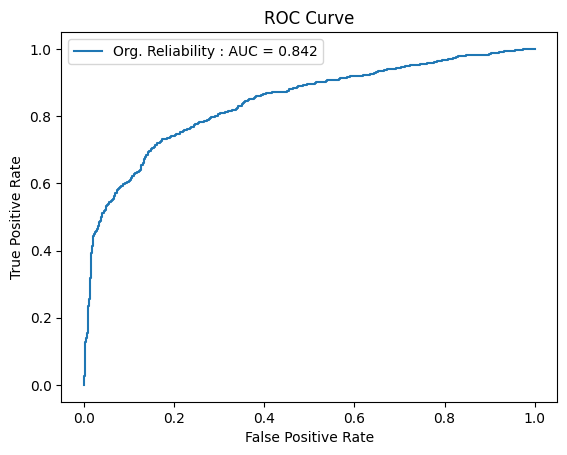

In [65]:
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score

def evaluate_ap_and_auroc(test_labels, test_preds, exp_names):
  '''
  INPUT
      - test_labels : binary verdicts from test set / list(np.ndarray)
      - test_preds : 'probability' predictions of the model on test set / list(np.npdarray)
      - exp_names : name of each experiment / list(string)
  '''

  assert len(test_labels) == len(test_preds) and len(test_labels) == len(exp_names), \
          "Length of each list should be identical."

  for labels, preds, exp_name in zip(test_labels, test_preds, exp_names):
    fpr, tpr, thresholds = roc_curve(labels, preds)
    auc = roc_auc_score(labels, preds)
    ap = average_precision_score(labels, preds)
    plt.plot(fpr, tpr, label=f'{exp_name} : AUC = {auc:.3f}')
    print(f"[*] {exp_name} : AP = {ap:.3f}, AUROC = {auc:.3f}")

  print("-" * 50)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve')
  plt.legend()
  plt.show()


test_preds = [test_preds_probs_best]
test_labels = [y_test_tensor.numpy()] * len(test_preds)
exp_names = ['Org. Reliability']

evaluate_ap_and_auroc(test_labels, test_preds, exp_names)

(Optional) Save model predictions for further comparison

In [ ]:
EXP_NAME = "originator_reliability"
PATH = f"/content/drive/MyDrive/Colab Notebooks/Intro_to_Machine_Learning/weights/{EXP_NAME}_best_preds.npy"

test_preds_probs_best_np = test_preds_probs_best.detach().cpu().numpy()
torch.save(best_model.state_dict(), PATH)

with open(PATH, 'wb') as f:
    np.save(f, test_preds_probs_best)

### Appendix. Ablation Study

w/o Sentence BERT Embedding
- The performance of the model significantly degrades without Sentence BERT embeeddings

In [ ]:
from sklearn.metrics import classification_report

best_model.eval()
with torch.no_grad():
    test_preds = best_model(X_test_tensor).round().squeeze()

print(classification_report(y_test_tensor, test_preds))

              precision    recall  f1-score   support

         0.0       0.78      0.75      0.76      1666
         1.0       0.65      0.69      0.67      1159

    accuracy                           0.72      2825
   macro avg       0.71      0.72      0.72      2825
weighted avg       0.73      0.72      0.72      2825

